# DashToon - Engineer, Generative AI


## Development of an Adaptable Deep Learning Model for Artistic Style Transfer

The aim of this assignment is to create a deep learning model capable of adapting an existing work to resemble the aesthetic of any art. The model should be able to analyze the artistic style of the selected art and apply similar stylistic features to a new, original artwork, creating a piece that seems as though it could have been created by the artist themselves.

## Task Description:

### 1.  Model Architecture:
- Design a neural network that can learn features representative of an artist's style. Consider using a convolutional neural network (CNN) as the basis for this model.

Convolutional Neural Network Based model are very good at learning the feature representations for images. Many popular architectures exist, of which in this example I am using the VGG11 model architecture along with its pre-trained weights. The VGG16 model was trained for Image Classification task on the ImageNet dataset which contains over 14 million images belonging to 1000 classes. 

In [1]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [2]:
vgg = models.vgg11(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

/home/thishyan/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/thishyan/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace=True)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=

In [3]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [4]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [5]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    if layers is None:
        layers = {'0': 'conv1_1',
                  '6': 'conv2_1', 
                  '11': 'conv3_1', 
                  '13': 'conv4_1',
                  '16': 'conv4_2',  ## content representation output
                  '18': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

- Implement a style transfer algorithm that leverages learned features to stylize input images.

In [6]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    batch_size, d, h, w = tensor.size()

    tensor = tensor.view(d,h*w)

    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [7]:
def transfer_image(target, style_features, content_features, style_grams, style_weights, content_loss_weight, style_loss_weight):
    show_every = 400

    # iteration hyperparameters
    optimizer = optim.Adam([target], lr=0.003)
    steps = 2000  # decide how many iterations to update your image (5000)

    for ii in tqdm(range(1, steps+1)):

        ## TODO: get the features from your target image    
        target_features = get_features(target, vgg)

        ## Then calculate the content loss
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        # the style loss
        # initialize the style loss to 0
        style_loss = 0

        # iterate through each style layer and add to the style loss
        for layer in style_weights:
            # get the "target" style representation for the layer
            target_feature = target_features[layer]

            ## TODO: Calculate the target gram matrix
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape

            # get the "style" style representation
            style_gram = style_grams[layer]

            # the style loss for one layer, weighted appropriately
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

            # add to the style loss
            style_loss += layer_style_loss / (d * h * w)


        ## TODO:  calculate the *total* loss
        total_loss = content_loss_weight * content_loss + style_loss_weight * style_loss

        ## -- do not need to change code, below -- ##
        # update your target image
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # display intermediate images and print the loss
        if  ii % show_every == 0:
            print('Total loss: ', total_loss.item())
            print('Content loss: ', content_loss.item())
            print('Style loss: ', style_loss.item())
            plt.imshow(im_convert(target))
            plt.show()
            
    return style_loss, content_loss, total_loss

### 2. Training:
- Train your model using the collected dataset(Find a dataset of your choice). Ensure to use a training-validation-test split to evaluate the model’s performance properly.
- Use appropriate loss functions to measure both content preservation and style emulation.

In [8]:
content1 = load_image('Images/Content/cat.jpg').to(device)

style1 = load_image('Images/Style/sunrise.jpg', shape=content1.shape[-2:]).to(device)

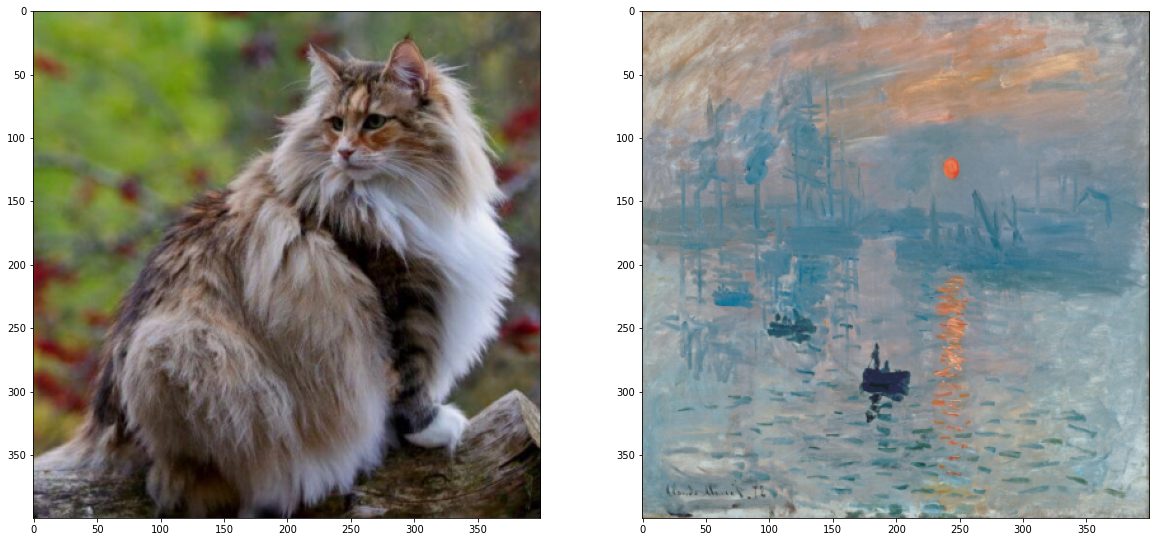

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content1))
ax2.imshow(im_convert(style1))

In [10]:
content1_features = get_features(content1, vgg)
style1_features = get_features(style1, vgg)

# calculate the gram matrices for each layer of our style representation
style1_grams = {layer: gram_matrix(style1_features[layer]) for layer in style1_features} # dic to store layer name : gram matrix

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target1 = content1.clone().requires_grad_(True).to(device)

In [11]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.75,
                 'conv4_1': 0.75,
                 'conv5_1': 0.5}

# you may choose to leave these as is
alpha = 1  # content_loss_scaling_factor
beta = 1e6  # style_loss_scaling_factor

  0%|          | 0/2000 [00:00<?, ?it/s]

Total loss:  583872.375
Content loss:  2.1801252365112305
Style loss:  0.5838701725006104


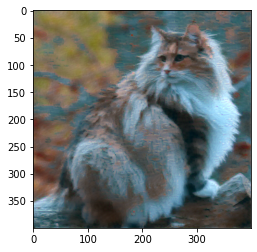

Total loss:  336933.5625
Content loss:  2.3039913177490234
Style loss:  0.3369312584400177


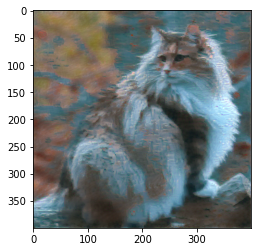

Total loss:  236216.234375
Content loss:  2.3538901805877686
Style loss:  0.23621387779712677


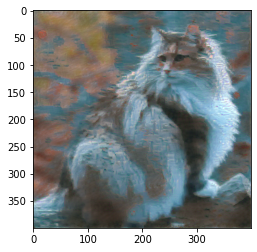

Total loss:  173360.0625
Content loss:  2.3807082176208496
Style loss:  0.17335768043994904


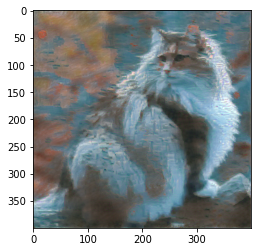

Total loss:  127702.7890625
Content loss:  2.4013137817382812
Style loss:  0.12770038843154907


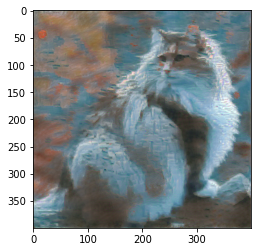

In [12]:
style_loss1, content_loss1, total_loss1 = transfer_image(target1, style1_features, content1_features, style1_grams, style_weights, alpha, beta)

### 3. Style Adaptation:
- Develop a method to adapt the learned style features to new works while maintaining the original content and integrity of the artwork.

In [13]:
content2 = load_image('Images/Content/cat.jpg').to(device)

style2 = load_image('Images/Style/scream.jpg', shape=content2.shape[-2:]).to(device)

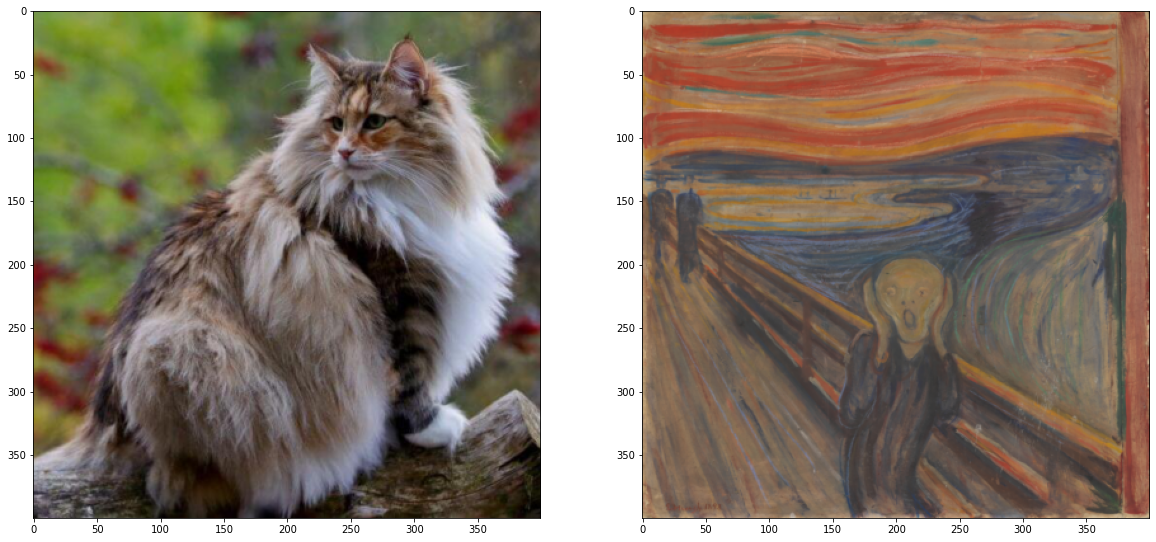

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content2))
ax2.imshow(im_convert(style2))

In [15]:
content2_features = get_features(content2, vgg)
style2_features = get_features(style2, vgg)

# calculate the gram matrices for each layer of our style representation
style2_grams = {layer: gram_matrix(style2_features[layer]) for layer in style2_features} # dic to store layer name : gram matrix

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target2 = content2.clone().requires_grad_(True).to(device)

In [16]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 1,
                 'conv3_1': 1,
                 'conv4_1': 1,
                 'conv5_1': 1}

# you may choose to leave these as is
alpha = 1  # content_loss_scaling_factor
beta = 50000  # style_loss_scaling_factor

  0%|          | 0/2000 [00:00<?, ?it/s]

Total loss:  17719.8125
Content loss:  2.3254354000091553
Style loss:  0.3543497323989868


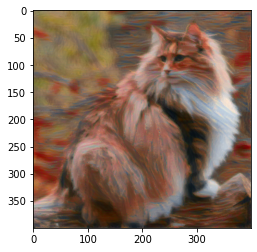

Total loss:  5712.95166015625
Content loss:  2.486225128173828
Style loss:  0.11420930922031403


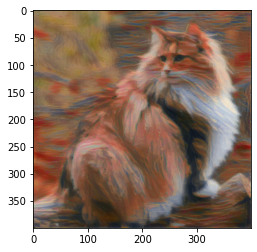

Total loss:  3223.377197265625
Content loss:  2.5443530082702637
Style loss:  0.06441665440797806


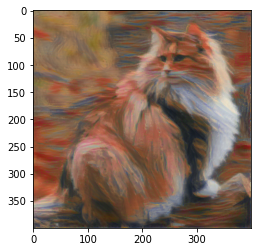

Total loss:  2194.2734375
Content loss:  2.569913625717163
Style loss:  0.04383407160639763


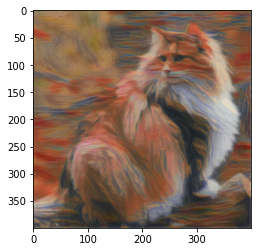

Total loss:  1620.7554931640625
Content loss:  2.5902352333068848
Style loss:  0.03236330673098564


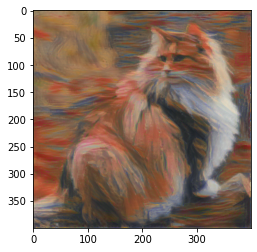

In [17]:
style_loss2, content_loss2, total_loss2 = transfer_image(target2, style2_features, content2_features, style2_grams, style_weights, alpha, beta)

### 4. Evaluation:
- Create a set of criteria to evaluate the effectiveness of the style transfer, such as stylistic accuracy, content preservation, and visual appeal.

We can use style transfer loss to evaluate stylistic accuracy and content transfer loss to evaluate the content preservation accuracy.

In [18]:
print(f"Style loss for image 1 : {style_loss1.item()}")
print(f"Content loss for image 1 : {content_loss1.item()}")

Style loss for image 1 : 0.12770038843154907
Content loss for image 1 : 2.4013137817382812


In [19]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
lpips = LearnedPerceptualImagePatchSimilarity(net_type="vgg", normalize = True).to(device)

target1 = target1 - target1.min()
target1_max = target1.max()
target1 = target1/target1_max

content1 = content1 - content1.min()
content1_max = content1.max()
content1 = content1/content1_max

style1 = style1 - style1.min()
style1_max = style1.max()
style1 = style1/style1_max

print(lpips(target1, content1))
print(lpips(target1, style1))

/home/thishyan/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/thishyan/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor(0.6622, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(0.6355, device='cuda:0', grad_fn=<SqueezeBackward0>)


In [20]:
print(f"Style loss for image 2 : {style_loss2.item()}")
print(f"Content loss for image 2 : {content_loss2.item()}")

Style loss for image 2 : 0.03236330673098564
Content loss for image 2 : 2.5902352333068848


In [21]:
target2 = target2 - target2.min()
target2_max = target2.max()
target2 = target2/target2_max

content2 = content2 - content2.min()
content2_max = content2.max()
content2 = content2/content2_max

style2 = style2 - style2.min()
style2_max = style2.max()
style2 = style2/style2_max

print(lpips(target2, content2))
print(lpips(target2, style2))

tensor(0.6313, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(0.6611, device='cuda:0', grad_fn=<SqueezeBackward0>)
